# Preprocessing of IMU

In this notebook, we detail how to preprocess IMU data for the DISSeCT pipeline and in particular how to obtain attitude estimate and manipulate the results.

N.B. This data was already offset-subtracted and the recording axes flipped to match our head reference frame convention (x towards the snout, y to the left of the head, z to the top of the head).

## Imports and data loading

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from cycler import cycler
from ahrs.filters import EKF

sr = 300.  # sampling rate, Hz


RGB = ["#D55E00", "#009E73", "#0072B2"]
RGB_CYCLER = cycler(color=RGB)

# Columns
COL_ACC = ["ax", "ay", "az"]  # accelerometer
COL_GYR = ["gx", "gy", "gz"]  # gyroscope

COL_ACC_G  = ["ax_G", "ay_G", "az_G"]  # gravitational acceleration
COL_ACC_R = ["ax_R", "ay_R", "az_R"]  # non-gravitational acceleration
COL_QUAT = ["qx", "qy", "qz", "qw"]  # quaternion from AHRS filter

In [2]:
# pandas' version might impact pickle loading
pd.__version__

'1.3.5'

In [3]:
# Load the example file
df = pd.read_pickle("../data_example/example_imu.pickle")

# The stored example is already preprocessed, we only keep the raw measurements here 
df = df[COL_ACC + COL_GYR]

df["time"] = np.arange(len(df)) / sr
df = df[:90000]  # keep the first five minutes of recording

df.head(5)

,ax,ay,az,gx,gy,gz,time
counter,,,,,,,
703455,-0.437201,0.124428,0.529188,-51.788330,74.554443,15.106201,0.000000
703456,-0.487250,0.114418,0.469129,-61.309814,59.326172,13.824463,0.003333
703457,-0.593939,-0.029137,0.406385,-63.079834,46.936035,13.214111,0.006667
703458,-0.818793,-0.141930,0.328016,-51.116943,38.574219,7.049561,0.010000
703459,-1.048041,-0.175133,0.322156,-39.978027,27.465820,6.164551,0.013333


## Plot example accelerometer and gyroscope measurements

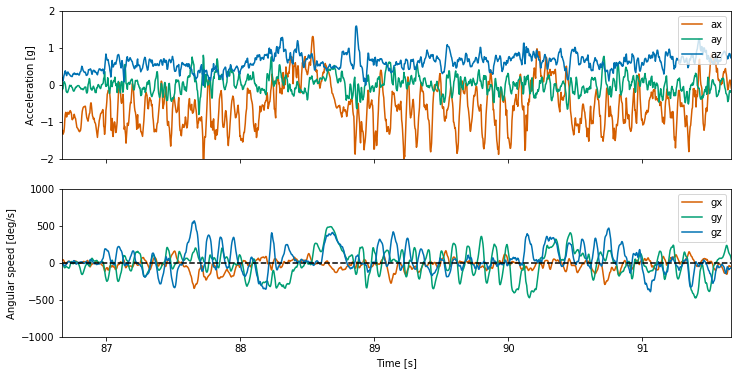

In [4]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

for ax in axs:
    ax.set_prop_cycle(RGB_CYCLER)

    
iloc_start = 26000
duration = 1500  # duration to plot, in IMU samples

iloc_end = iloc_start + duration - 1
t_start, t_end = df.iloc[iloc_start].time, df.iloc[iloc_end].time

df.iloc[iloc_start:iloc_start + duration].plot(x="time", y=COL_ACC, ax=axs[0])
df.iloc[iloc_start:iloc_start + duration].plot(x="time", y=COL_GYR, ax=axs[1])

axs[1].plot([t_start, t_end], [0, 0], c="k", linestyle="--")
axs[1].set_xlim([t_start, t_end])
axs[0].set_ylim([-2, 2])
axs[1].set_ylim([-1000, 1000])

axs[0].set_ylabel("Acceleration [g]")
axs[1].set_ylabel("Angular speed [deg/s]")
axs[1].set_xlabel("Time [s]")


for ax in axs:
    ax.legend(loc="upper right")

## Attitude (tilt) estimate
Also see [Fayat et al., 2021](https://doi.org/10.3390/s21186318) and the [associated code](https://github.com/rfayat/sensors_IMU_head_tilt_rodents) for the justification of the hyperparameters as well as for more computationally efficient alternatives to this implementation of the EKF filter.

### AHRS filtering using an Extended Kalman Filter

In [5]:
%%time
ekf_filter = EKF(gyr=np.radians(df[COL_GYR].values),  # in RADIAN/s
                 acc=df[COL_ACC].values,
                 frequency=sr,
                 frame="ENU",
                 var_acc=2e-3,
                 var_gyr=.75)

CPU times: user 20 s, sys: 255 µs, total: 20 s
Wall time: 20 s


### Estimate of gravitationnal acceleration in the head reference frame

In [6]:
# WARNING
# the ahrs toolbox returns the quaternions with order [qw, qx, qy, qz]
# here we match scipy's order, i.e. [qx, qy, qz, qw]
quaternion_sensor2earth = ekf_filter.Q[:, [1, 2, 3, 0]]

rot_sensor2earth = R.from_quat(quaternion_sensor2earth)
rot_earth2sensor = rot_sensor2earth.inv()

# Earth vertical ([0, 0, 1]) in the head reference frame
acc_G = rot_earth2sensor.apply(np.array([0., 0., 1.]))
acc_R = df[COL_ACC].values - acc_G

### Consolidate the results and example plot

In [7]:
df_quat = pd.DataFrame(quaternion_sensor2earth, index=df.index, columns=COL_QUAT)
df_acc_G = pd.DataFrame(acc_G, index=df.index, columns=COL_ACC_G)
df_acc_R = pd.DataFrame(acc_R, index=df.index, columns=COL_ACC_R)

df_preprocessed = df.join(df_quat).join(df_acc_G).join(df_acc_R)
df_preprocessed.head(5)

,ax,ay,az,gx,gy,gz,time,qx,qy,qz,qw,ax_G,ay_G,az_G,ax_R,ay_R,az_R
counter,,,,,,,,,,,,,,,,,
703455,-0.437201,0.124428,0.529188,-51.788330,74.554443,15.106201,0.000000,0.108667,0.330012,-0.038276,0.936920,-0.626708,0.178362,0.758567,0.189507,-0.053934,-0.229379
703456,-0.487250,0.114418,0.469129,-61.309814,59.326172,13.824463,0.003333,0.110625,0.389789,-0.041640,0.913287,-0.721191,0.169602,0.671654,0.233941,-0.055184,-0.202525
703457,-0.593939,-0.029137,0.406385,-63.079834,46.936035,13.214111,0.006667,0.329275,0.191478,-0.768666,0.513874,-0.702997,0.044046,0.709828,0.109057,-0.073183,-0.303443
703458,-0.818793,-0.141930,0.328016,-51.116943,38.574219,7.049561,0.010000,0.386625,0.197573,-0.860031,0.268016,-0.770924,-0.132595,0.622973,-0.047869,-0.009335,-0.294957
703459,-1.048041,-0.175133,0.322156,-39.978027,27.465820,6.164551,0.013333,0.413260,0.183231,-0.870297,0.195514,-0.790967,-0.157334,0.591285,-0.257075,-0.017799,-0.269129


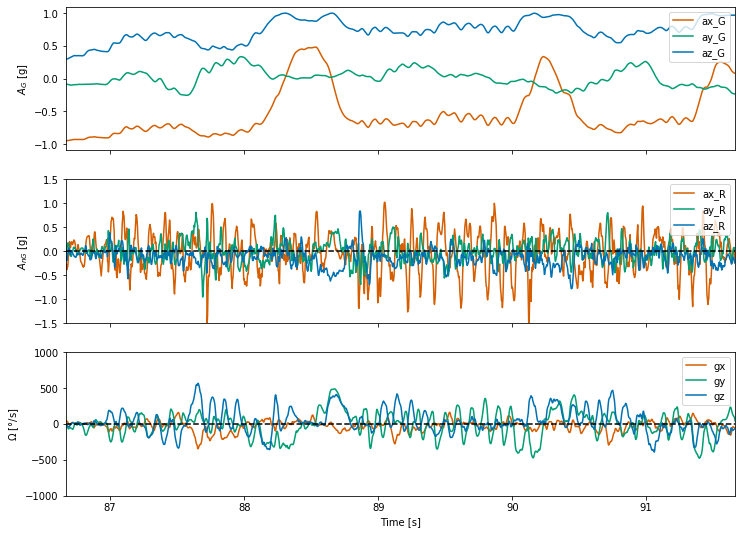

In [8]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 9))

for ax in axs:
    ax.set_prop_cycle(RGB_CYCLER)


df_preprocessed.iloc[iloc_start:iloc_start + duration].plot(x="time", y=COL_ACC_G, ax=axs[0])
df_preprocessed.iloc[iloc_start:iloc_start + duration].plot(x="time", y=COL_ACC_R, ax=axs[1])
df_preprocessed.iloc[iloc_start:iloc_start + duration].plot(x="time", y=COL_GYR, ax=axs[2])

axs[1].plot([t_start, t_end], [0, 0], c="k", linestyle="--")
axs[2].plot([t_start, t_end], [0, 0], c="k", linestyle="--")
axs[2].set_xlim([t_start, t_end])

axs[0].set_ylim([-1.1, 1.1])
axs[1].set_ylim([-1.5, 1.5])
axs[2].set_ylim([-1000, 1000])

axs[0].set_ylabel("$A_G$ [g]")
axs[1].set_ylabel("$A_{nG}$ [g]")
axs[2].set_ylabel("$\Omega$ [°/s]")
axs[2].set_xlabel("Time [s]")


for ax in axs:
    ax.legend(loc="upper right")

## Consolidated pipeline
The previous steps can be performed using the helper functions in dissect.angles with hard-coded hyperparameters.

In [9]:
import sys
sys.path.append("..")
from dissect import angles as ah  # ah: angle helper

In [10]:
%%time
quaternion_sensor2earth = ah.compute_quaternion_sensor2earth(df[COL_GYR].values,
                                                             df[COL_ACC].values,
                                                             sr=300.)
acc_G = ah.get_gravitational_acc(quaternion_sensor2earth)
acc_G[:5]

CPU times: user 20.2 s, sys: 0 ns, total: 20.2 s
Wall time: 20.2 s


array([[-0.62670849,  0.17836164,  0.75856681],
       [-0.72119081,  0.16960246,  0.67165379],
       [-0.70299667,  0.04404647,  0.70982785],
       [-0.7709239 , -0.1325946 ,  0.62297272],
       [-0.79096651, -0.15733407,  0.59128501]])